# Introducing Keras

Let's use Keras on the MNIST data set again, this time using a Convolutional Neural Network that's better suited for image processing. CNN's are less sensitive to where in the image the pattern is that we're looking for.

With a multi-layer perceptron, we achieved around 97% accuracy. Let's see if we can beat that.

As before we'll start by importing the stuff we need, including the new layer types we talked about:

In [226]:
import os
import tensorflow as tf
from tensorflow import keras 
from tensorflow.keras.layers import (Dense, Conv1D, Flatten, Activation, BatchNormalization, Activation, Dropout)
from tensorflow.keras import Sequential, regularizers, optimizers
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as spio

We'll load up our raw data set exactly as before:

In [282]:
mat_files=spio.loadmat('Abemaciclib_Data_NIR_clean.mat')
SPEC_CAL = mat_files['SPEC_B_PLS_TRAINING']
Y_CAL = mat_files['Y_BC_PLS_TRAINING_ALL_SPECIES']
SPEC_TEST = mat_files['SPEC_B_PLS_TRAINING']
Y_TEST = mat_files['Y_BC_PLS_TRAINING_ALL_SPECIES']
WL_AXIS=mat_files['WL_AXIS_B']
WL_AXIS=WL_AXIS.transpose();
SPEC_CAL=SPEC_CAL
SPEC_TEST=SPEC_TEST
Y_CAL=Y_CAL[:,0:2]
Y_TEST=Y_TEST[:,0:2]
SPEC_CAL = SPEC_CAL.reshape(SPEC_CAL.shape[0],SPEC_CAL.shape[1],1)
SPEC_TEST = SPEC_TEST.reshape(SPEC_TEST.shape[0],SPEC_TEST.shape[1],1)

SPEC_CAL.shape
Y_TEST.shape

(1600, 2)

We need to shape the data differently then before. Since we're treating the data as 2D images of 28x28 pixels instead of a flattened stream of 784 pixels, we need to shape it accordingly. Depending on the data format Keras is set up for, this may be 1x28x28 or 28x28x1 (the "1" indicates a single color channel, as this is just grayscale. If we were dealing with color images, it would be 3 instead of 1 since we'd have red, green, and blue color channels)

As before we need to convert our train and test labels to be categorical in one-hot format:

As a sanity check let's print out one of the training images with its label:

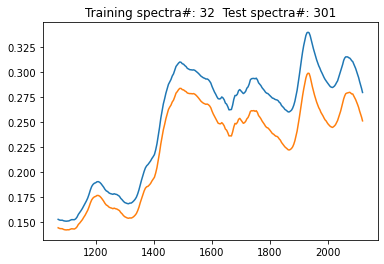

In [280]:
import matplotlib.pyplot as plt

def display_sample(num1,num2):
    #Print training and test spectra 
    fig, ax = plt.subplots()
    ax.plot(WL_AXIS,SPEC_CAL[num1,:])
    ax.plot(WL_AXIS,SPEC_TEST[num2,:])
    plt.title('Training spectra#: %d  Test spectra#: %d' % (num1, num2))
    plt.show()
    
display_sample(32,301)

Now for the meat of the problem. Setting up a convolutional neural network involves more layers. Not all of these are strictly necessary; you could run without pooling and dropout, but those extra steps help avoid overfitting and help things run faster.

We'll start with a 2D convolution of the image - it's set up to take 32 windows, or "filters", of each image, each filter being 3x3 in size.

We then run a second convolution on top of that with 64 3x3 windows - this topology is just what comes recommended within Keras's own examples. Again you want to re-use previous research whenever possible while tuning CNN's, as it is hard to do.

Next we apply a MaxPooling2D layer that takes the maximum of each 2x2 result to distill the results down into something more manageable.

A dropout filter is then applied to prevent overfitting.

Next we flatten the 2D layer we have at this stage into a 1D layer. So at this point we can just pretend we have a traditional multi-layer perceptron...

... and feed that into a hidden, flat layer of 128 units.

We then apply dropout again to further prevent overfitting.

And finally, we feed that into our final 10 units where softmax is applied to choose our category of 0-9.

In [283]:
model = Sequential()
model.add(Conv1D(filters=1, kernel_size=11, strides=1, padding='same', activation='relu', input_shape=(SPEC_CAL.shape[1],1),
                 kernel_initializer='VarianceScaling', kernel_regularizer=regularizers.l2(0.1)))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.1))
model.add(Dense(32, kernel_initializer='VarianceScaling', kernel_regularizer=regularizers.l2(0.1)))
model.add(Dense(2))

# Function: the MAPE metric
#def mape(y_true, y_pred):
#    return np.mean(np.abs(((y_true - y_pred) / y_true))) * 100


# Function: build the CNN model with different parameters like filters, l2.
#def build_model(filters=8, kernel_size=200, l2=0.0001, dropout_ratio=0.2, units=32):
#    model = Sequential()

    # construct the model structure
    # the convolutional layer with ReLu activation
#    model.add(
#        Conv1D(filters=filters,
#               kernel_size=kernel_size,
#               strides=1,
#               activation='relu',
#               padding='same',
#               input_shape=(SPEC_CAL.shape[1], 1),
#               kernel_initializer='VarianceScaling',
#               kernel_regularizer=regularizers.l2(l2)))

#    model.add(Flatten())
#    model.add(BatchNormalization())
#    model.add(Activation('relu'))
#    model.add(Dropout(dropout_ratio))
#    model.add(Dense(units, kernel_initializer='VarianceScaling', kernel_regularizer=regularizers.l2(l2)))

    # the output layer
#    model.add(Dense(1))
#    return model

Let's double check the model description:

In [284]:

# build model
#model = build_model(filters=2, kernel_size=11, l2=0.1, dropout_ratio=0.1, units=32)
optimizer = optimizers.Adam(lr=0.001)

# use earlystop to avoid overfitting and to save training time
earlystop = keras.callbacks.EarlyStopping(patience=500)

# use checkpoint to save the best model while training
if os.path.isdir("./weights/qft"):
    pass
else:
    os.mkdir("./weights/qft")
weight_path = "./weights/qft/weights_best_qft_mse_demo.hdf5"
checkpoint = keras.callbacks.ModelCheckpoint(weight_path, monitor='val_loss', verbose=0, save_best_only=True)

model.summary()



Model: "sequential_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 256, 1)            12        
_________________________________________________________________
flatten_25 (Flatten)         (None, 256)               0         
_________________________________________________________________
batch_normalization_25 (Batc (None, 256)               1024      
_________________________________________________________________
activation_25 (Activation)   (None, 256)               0         
_________________________________________________________________
dropout_25 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_48 (Dense)             (None, 32)                8224      
_________________________________________________________________
dense_49 (Dense)             (None, 2)               

We are still doing multiple categorization, so categorical_crossentropy is still the right loss function to use. We'll use the Adam optimizer, although the example provided with Keras uses RMSProp. You might want to try both if you have time.

In [285]:
# define the loss function: 'mse'/'mape'/'mae'
model.compile(optimizer=optimizer, loss='mse', metrics=['mse'])

And now we train our model... to make things go a little faster, we'll use batches of 32.

## Warning

This could take hours to run, and your computer's CPU will be maxed out during that time! Don't run the next block unless you can tie up your computer for a long time. It will print progress as each epoch is run, but each epoch can take around 20 minutes.

In [287]:
# model training process
history = model.fit(
    x=SPEC_CAL,
    y=Y_CAL,
    batch_size=800,  # mini-batch size
    epochs=500,
    verbose=1,
    validation_data=(SPEC_TEST, Y_TEST),
    callbacks=[earlystop, checkpoint])
del history

Epoch 1/500
2/2 [==============================] - 0s 44ms/step - loss: 5.4555 - mse: 2.4069 - val_loss: 212.4757 - val_mse: 209.4297
Epoch 2/500
2/2 [==============================] - 0s 28ms/step - loss: 5.4159 - mse: 2.3701 - val_loss: 159.7301 - val_mse: 156.6862
Epoch 3/500
2/2 [==============================] - 0s 27ms/step - loss: 5.3652 - mse: 2.3224 - val_loss: 149.4590 - val_mse: 146.4185
Epoch 4/500
2/2 [==============================] - 0s 28ms/step - loss: 5.3064 - mse: 2.2669 - val_loss: 187.1333 - val_mse: 184.0955
Epoch 5/500
2/2 [==============================] - 0s 30ms/step - loss: 5.3147 - mse: 2.2775 - val_loss: 214.3661 - val_mse: 211.3315
Epoch 6/500
2/2 [==============================] - 0s 28ms/step - loss: 5.3215 - mse: 2.2879 - val_loss: 182.4577 - val_mse: 179.4283
Epoch 7/500
2/2 [==============================] - 0s 28ms/step - loss: 5.3438 - mse: 2.3159 - val_loss: 146.3640 - val_mse: 143.3404
Epoch 8/500
2/2 [==============================] - 0s 28ms/ste

2/2 [==============================] - 0s 29ms/step - loss: 5.0166 - mse: 2.1873 - val_loss: 44.6174 - val_mse: 41.7895
Epoch 63/500
2/2 [==============================] - 0s 28ms/step - loss: 5.0614 - mse: 2.2340 - val_loss: 36.5255 - val_mse: 33.7000
Epoch 64/500
2/2 [==============================] - 0s 29ms/step - loss: 5.0395 - mse: 2.2145 - val_loss: 41.2329 - val_mse: 38.4104
Epoch 65/500
2/2 [==============================] - 0s 29ms/step - loss: 5.0304 - mse: 2.2093 - val_loss: 52.2262 - val_mse: 49.4099
Epoch 66/500
2/2 [==============================] - 0s 29ms/step - loss: 5.0390 - mse: 2.2249 - val_loss: 59.8934 - val_mse: 57.0841
Epoch 67/500
2/2 [==============================] - 0s 29ms/step - loss: 4.9974 - mse: 2.1887 - val_loss: 42.8221 - val_mse: 40.0158
Epoch 68/500
2/2 [==============================] - 0s 29ms/step - loss: 5.0848 - mse: 2.2787 - val_loss: 31.5223 - val_mse: 28.7172
Epoch 69/500
2/2 [==============================] - 0s 29ms/step - loss: 5.0316 - 

2/2 [==============================] - 0s 26ms/step - loss: 4.6987 - mse: 2.0664 - val_loss: 19.6829 - val_mse: 17.0527
Epoch 124/500
2/2 [==============================] - 0s 30ms/step - loss: 4.8249 - mse: 2.1950 - val_loss: 19.2765 - val_mse: 16.6487
Epoch 125/500
2/2 [==============================] - 0s 29ms/step - loss: 4.6695 - mse: 2.0433 - val_loss: 21.5346 - val_mse: 18.9120
Epoch 126/500
2/2 [==============================] - 0s 27ms/step - loss: 4.7855 - mse: 2.1636 - val_loss: 29.1098 - val_mse: 26.4906
Epoch 127/500
2/2 [==============================] - 0s 26ms/step - loss: 4.7468 - mse: 2.1289 - val_loss: 22.7361 - val_mse: 20.1208
Epoch 128/500
2/2 [==============================] - 0s 27ms/step - loss: 4.7258 - mse: 2.1112 - val_loss: 14.5640 - val_mse: 11.9505
Epoch 129/500
2/2 [==============================] - 0s 29ms/step - loss: 4.7346 - mse: 2.1206 - val_loss: 14.3261 - val_mse: 11.7127
Epoch 130/500
2/2 [==============================] - 0s 28ms/step - loss: 4.

2/2 [==============================] - 0s 28ms/step - loss: 4.5003 - mse: 2.0491 - val_loss: 12.8801 - val_mse: 10.4302
Epoch 185/500
2/2 [==============================] - 0s 29ms/step - loss: 4.5907 - mse: 2.1403 - val_loss: 12.8937 - val_mse: 10.4432
Epoch 186/500
2/2 [==============================] - 0s 30ms/step - loss: 4.5198 - mse: 2.0700 - val_loss: 10.9870 - val_mse: 8.5388
Epoch 187/500
2/2 [==============================] - 0s 30ms/step - loss: 4.4907 - mse: 2.0433 - val_loss: 13.7792 - val_mse: 11.3354
Epoch 188/500
2/2 [==============================] - 0s 30ms/step - loss: 4.4558 - mse: 2.0133 - val_loss: 20.3472 - val_mse: 17.9093
Epoch 189/500
2/2 [==============================] - 0s 29ms/step - loss: 4.5145 - mse: 2.0779 - val_loss: 18.3133 - val_mse: 15.8793
Epoch 190/500
2/2 [==============================] - 0s 35ms/step - loss: 4.4555 - mse: 2.0220 - val_loss: 10.9839 - val_mse: 8.5510
Epoch 191/500
2/2 [==============================] - 0s 35ms/step - loss: 4.54

2/2 [==============================] - 0s 29ms/step - loss: 4.2313 - mse: 1.9350 - val_loss: 14.1035 - val_mse: 11.8069
Epoch 246/500
2/2 [==============================] - 0s 29ms/step - loss: 4.2688 - mse: 1.9734 - val_loss: 16.0575 - val_mse: 13.7667
Epoch 247/500
2/2 [==============================] - 0s 29ms/step - loss: 4.2193 - mse: 1.9299 - val_loss: 12.3717 - val_mse: 10.0858
Epoch 248/500
2/2 [==============================] - 0s 30ms/step - loss: 4.2877 - mse: 2.0022 - val_loss: 10.5172 - val_mse: 8.2328
Epoch 249/500
2/2 [==============================] - 0s 28ms/step - loss: 4.2574 - mse: 1.9726 - val_loss: 14.2636 - val_mse: 11.9789
Epoch 250/500
2/2 [==============================] - 0s 28ms/step - loss: 4.2988 - mse: 2.0145 - val_loss: 14.7391 - val_mse: 12.4559
Epoch 251/500
2/2 [==============================] - 0s 28ms/step - loss: 4.2324 - mse: 1.9498 - val_loss: 12.7741 - val_mse: 10.4953
Epoch 252/500
2/2 [==============================] - 0s 28ms/step - loss: 4.3

2/2 [==============================] - 0s 28ms/step - loss: 4.0657 - mse: 1.9240 - val_loss: 7.6042 - val_mse: 5.4592
Epoch 307/500
2/2 [==============================] - 0s 30ms/step - loss: 4.1040 - mse: 1.9588 - val_loss: 8.1195 - val_mse: 5.9731
Epoch 308/500
2/2 [==============================] - 0s 28ms/step - loss: 4.1215 - mse: 1.9757 - val_loss: 10.9849 - val_mse: 8.8400
Epoch 309/500
2/2 [==============================] - 0s 27ms/step - loss: 4.0811 - mse: 1.9371 - val_loss: 14.7324 - val_mse: 12.5916
Epoch 310/500
2/2 [==============================] - 0s 28ms/step - loss: 4.0093 - mse: 1.8703 - val_loss: 12.3443 - val_mse: 10.2088
Epoch 311/500
2/2 [==============================] - 0s 29ms/step - loss: 4.1487 - mse: 2.0125 - val_loss: 13.1050 - val_mse: 10.9700
Epoch 312/500
2/2 [==============================] - 0s 29ms/step - loss: 4.0745 - mse: 1.9404 - val_loss: 11.7319 - val_mse: 9.5999
Epoch 313/500
2/2 [==============================] - 0s 28ms/step - loss: 3.9714 -

2/2 [==============================] - 0s 28ms/step - loss: 3.8264 - mse: 1.8084 - val_loss: 15.5544 - val_mse: 13.5385
Epoch 368/500
2/2 [==============================] - 0s 28ms/step - loss: 3.8120 - mse: 1.7963 - val_loss: 12.7021 - val_mse: 10.6871
Epoch 369/500
2/2 [==============================] - 0s 28ms/step - loss: 3.8742 - mse: 1.8601 - val_loss: 7.2651 - val_mse: 5.2513
Epoch 370/500
2/2 [==============================] - 0s 27ms/step - loss: 3.7938 - mse: 1.7793 - val_loss: 10.4368 - val_mse: 8.4231
Epoch 371/500
2/2 [==============================] - 0s 28ms/step - loss: 3.8703 - mse: 1.8585 - val_loss: 17.7539 - val_mse: 15.7447
Epoch 372/500
2/2 [==============================] - 0s 28ms/step - loss: 3.9075 - mse: 1.8985 - val_loss: 13.9270 - val_mse: 11.9190
Epoch 373/500
2/2 [==============================] - 0s 28ms/step - loss: 3.8121 - mse: 1.8042 - val_loss: 9.6707 - val_mse: 7.6650
Epoch 374/500
2/2 [==============================] - 0s 27ms/step - loss: 3.9184 

2/2 [==============================] - 0s 28ms/step - loss: 3.6489 - mse: 1.7501 - val_loss: 12.4619 - val_mse: 10.5635
Epoch 429/500
2/2 [==============================] - 0s 27ms/step - loss: 3.6619 - mse: 1.7630 - val_loss: 13.4695 - val_mse: 11.5727
Epoch 430/500
2/2 [==============================] - 0s 30ms/step - loss: 3.6667 - mse: 1.7710 - val_loss: 10.9215 - val_mse: 9.0281
Epoch 431/500
2/2 [==============================] - 0s 27ms/step - loss: 3.6763 - mse: 1.7837 - val_loss: 8.8187 - val_mse: 6.9274
Epoch 432/500
2/2 [==============================] - 0s 27ms/step - loss: 3.6611 - mse: 1.7691 - val_loss: 9.7624 - val_mse: 7.8703
Epoch 433/500
2/2 [==============================] - 0s 28ms/step - loss: 3.6960 - mse: 1.8043 - val_loss: 12.0081 - val_mse: 10.1189
Epoch 434/500
2/2 [==============================] - 0s 28ms/step - loss: 3.6480 - mse: 1.7602 - val_loss: 10.3542 - val_mse: 8.4693
Epoch 435/500
2/2 [==============================] - 0s 27ms/step - loss: 3.6084 -

2/2 [==============================] - 0s 28ms/step - loss: 3.5959 - mse: 1.8026 - val_loss: 12.7170 - val_mse: 10.9258
Epoch 490/500
2/2 [==============================] - 0s 27ms/step - loss: 3.4614 - mse: 1.6719 - val_loss: 14.1019 - val_mse: 12.3173
Epoch 491/500
2/2 [==============================] - 0s 27ms/step - loss: 3.4707 - mse: 1.6875 - val_loss: 11.7829 - val_mse: 10.0023
Epoch 492/500
2/2 [==============================] - 0s 28ms/step - loss: 3.5136 - mse: 1.7330 - val_loss: 7.6852 - val_mse: 5.9019
Epoch 493/500
2/2 [==============================] - 0s 37ms/step - loss: 3.4440 - mse: 1.6600 - val_loss: 10.7310 - val_mse: 8.9465
Epoch 494/500
2/2 [==============================] - 0s 32ms/step - loss: 3.4442 - mse: 1.6599 - val_loss: 15.9475 - val_mse: 14.1655
Epoch 495/500
2/2 [==============================] - 0s 32ms/step - loss: 3.4907 - mse: 1.7097 - val_loss: 14.3871 - val_mse: 12.6095
Epoch 496/500
2/2 [==============================] - 0s 32ms/step - loss: 3.469

Was it worth the wait?

(10, 256, 1)
(1600, 256)


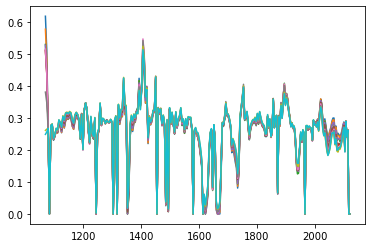

In [288]:
layers_output = [model.layers[i].output for i in range(len(model.layers))]
#print(layers_output[0].shape)

from tensorflow.keras import models

conv1D_model = models.Model(inputs=model.input, outputs=layers_output[4])
temp=SPEC_CAL[0:800:80,:,:]

print(temp.shape)
conv1D_output = conv1D_model.predict(SPEC_CAL)
print(conv1D_output.shape)
#first_layer_activation = activations[0]
#first_layer_activation.shape

from pylab import *
#for r in range(conv1D_output.shape[2]):
for i in range(temp.shape[0]):
        #subplot(conv1D_output.shape[2],1,r+1)
    plt.plot(WL_AXIS,conv1D_output[i, :])
    

Over 99%! And that's with just 10 epochs! And from the looks of it, 4 or 5 would have been enough. It came at a significant cost in terms of computing power, but when you start distributing things over multiple computers each with multiple GPU's, that cost starts to feel less bad. If you're building something where life and death are on the line, like a self-driving car, every fraction of a percent matters.

In [291]:
model.load_weights(weight_path)
ypred_test = model.predict(SPEC_TEST)
ypred_train = model.predict(SPEC_CAL)

print("\n")
print("train")
print(r2_score(Y_CAL.ravel(), ypred_train.ravel()))
print(np.sqrt(mean_squared_error(Y_CAL.ravel(), ypred_train.ravel())))
print(mape(Y_CAL.ravel(), ypred_train.ravel()))
print(mean_absolute_error(Y_CAL.ravel(), ypred_train.ravel()))
#print("\n")
#print("validation")
#print(r2_score(yval.ravel(), ypred_val.ravel()))
#print(np.sqrt(mean_squared_error(yval.ravel(), ypred_val.ravel())))
#print(mape(yval.ravel(), ypred_val.ravel()))
#print(mean_absolute_error(yval.ravel(), ypred_val.ravel()))
print("\n")
print("test")
print(r2_score(Y_TEST.ravel(), ypred_test.ravel()))
print(np.sqrt(mean_squared_error(Y_TEST.ravel(), ypred_test.ravel())))
print(mape(Y_TEST.ravel(), ypred_test.ravel()))
print(mean_absolute_error(Y_TEST.ravel(), ypred_test.ravel()))




train
0.8374894644234319
1.553930337854768
3.5187731912143443
1.279853859284847


test
0.8374894644234319
1.553930337854768
3.5187731912143443
1.279853859284847
(1600, 2)


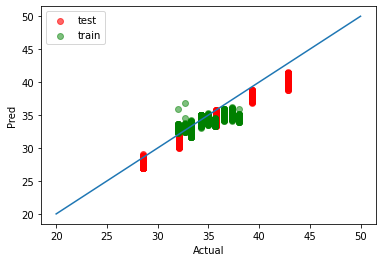

In [296]:
# plot  predicted values vs actual values
plt.scatter(Y_TEST[:,0], ypred_test[:,0], c='r', alpha=0.6, label='test')
plt.scatter(Y_CAL[:,1], ypred_train[:,1], c='g', alpha=0.5, label='train')
#plt.scatter(yval, ypred_val, c='b', alpha=0.5, label='val')
plt.plot(np.linspace(20, 50, 10), np.linspace(20, 50, 10))
plt.xlabel("Actual")
plt.ylabel("Pred")
plt.legend()
plt.show()

In [294]:
def sample_test(x):
    test_sample = SPEC_TEST[x,:].reshape(1,SPEC_TEST.shape[1],1)
    pred_label=model.predict(test_sample)
    label = Y_TEST[x]
    print('Observed value:', label)
    print('Predicted value:',pred_label)
#

sample_test(109)

Observed value: [42.852 33.25 ]
Predicted value: [[39.89983 33.7671 ]]
